In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import preprocessing
sns.set()

In [2]:
input_dir = 'C:/Users/vadim.sokolov/Desktop/В'
df = pd.read_excel(f'{input_dir}/test3/Задача по кластеризации1.xlsx', sheet_name='Data')

In [3]:
df.head()

,TradePointCode,STORE_LOCATION_LVL_NM1,STORE_LOCATION_NM,BrandName,Локация,Выкладка,Revenue,ChequeCount,TradeSquare,mean_ch,...,Простуда и грипп_общ,Борьба с вредными привычками_общ,Витамины и обмен веществ_общ,Лечебная и селективная косметика_общ,Масс-маркет_общ,Товары для матери и ребенка_общ,Уход за больными_общ,Медицинская техника_общ,Мед. изделия_общ,Продукты питания_общ
0,А00927,БЕ Центр,А00927 Орел Наугорское шоссе 88,Аптека.ру,Стрит,ОФТ,4.187031e+07,135717,98.00,308.511909,...,0.001059,0.000906,0.000824,0.000180,0.000783,0.001213,0.001116,0.001018,0.000959,0.001113
1,А02072,БЕ Сибирь,А02072 Новосибирск Дзержинского 30 Аптека,Аптека.ру,Стрит,ЗФТ,4.892518e+07,180023,53.00,271.771820,...,0.001378,0.001562,0.000789,0.000012,0.001122,0.001403,0.001193,0.001079,0.001492,0.001426
2,А02630,БЕ Москва,А02630 Москва ул. Островитянова 18,МосАптека,Стрит,ЗФТ,4.275123e+07,107701,45.54,396.943634,...,0.000977,0.000609,0.000699,0.000293,0.001142,0.000836,0.001603,0.000902,0.001011,0.000895
3,А02632,БЕ Москва,А02632 Москва ул. Нагатинская 11 корп 1,МосАптека,Стрит,ЗФТ,4.634328e+07,104647,60.35,442.853368,...,0.001105,0.001105,0.000995,0.000776,0.001132,0.001272,0.001024,0.000871,0.000925,0.000573
4,А00899,БЕ Центр,А00899 Орел Октябрьская 16/18,Озерки,Стрит,ЗФТ,6.355079e+07,178549,63.40,355.929102,...,0.001352,0.001004,0.001307,0.002186,0.001295,0.002059,0.000966,0.001241,0.001498,0.000962


### Кластеризация будет проведена в 2 этапа:
1) Разделение по территориальному признаку (Локация), и на основании общего количества чеков (Revenue/ChequeCount).   
2) Разделение получившихся кластеров на магазины с высоким/средним/низким ценовым сегментом (столбцы mean_ch/Revenue).

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 63 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   TradePointCode                        943 non-null    object 
 1   STORE_LOCATION_LVL_NM1                943 non-null    object 
 2   STORE_LOCATION_NM                     943 non-null    object 
 3   BrandName                             943 non-null    object 
 4   Локация                               943 non-null    object 
 5   Выкладка                              943 non-null    object 
 6   Revenue                               943 non-null    float64
 7   ChequeCount                           943 non-null    int64  
 8   TradeSquare                           943 non-null    float64
 9   mean_ch                               943 non-null    float64
 10  high                                  943 non-null    float64
 11  medium             

In [5]:
df['Локация_enc'] = df['Локация'].astype('category')
df['Выкладка_enc'] = df['Выкладка'].astype('category')

for col in ['Локация_enc', 'Выкладка_enc']:
     df[col] = df[col].cat.codes
        
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 65 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   TradePointCode                        943 non-null    object 
 1   STORE_LOCATION_LVL_NM1                943 non-null    object 
 2   STORE_LOCATION_NM                     943 non-null    object 
 3   BrandName                             943 non-null    object 
 4   Локация                               943 non-null    object 
 5   Выкладка                              943 non-null    object 
 6   Revenue                               943 non-null    float64
 7   ChequeCount                           943 non-null    int64  
 8   TradeSquare                           943 non-null    float64
 9   mean_ch                               943 non-null    float64
 10  high                                  943 non-null    float64
 11  medium             

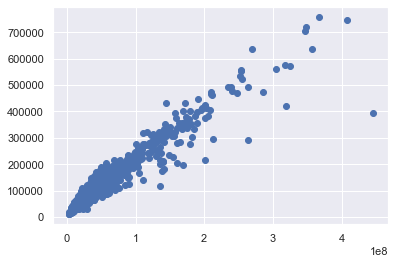

In [6]:
plt.scatter(df['Revenue'],df['ChequeCount'])

### 1.Разделение магазинов по количеству чеков  с учётом категориальных данных - Локации.
Кластеризация покажет, где ассортимент можно сделать шире (где высокое кол-во чеков), а где более узким.

In [7]:
cl_first = df.iloc[:,np.r_[7:8,63:64]]
cl_first.head()

,ChequeCount,Локация_enc
0,135717,5
1,180023,5
2,107701,5
3,104647,5
4,178549,5


Стандартизируем данные

In [8]:
x_scaled_1 = preprocessing.scale(cl_first)
x_scaled_1

array([[ 0.06195993,  0.15718426],
       [ 0.46623989,  0.15718426],
       [-0.19367831,  0.15718426],
       ...,
       [-0.46683601,  0.15718426],
       [-0.62987656,  0.15718426],
       [-0.58289336,  1.18652285]])

Посчитаем сумму квадратов для каждого кластера (WCSS) для определения наилучшего количества кластеров.

In [9]:
wcss = []
cl_num = 10
for i in range (1,cl_num):
    kmeans= KMeans(i)
    kmeans.fit(x_scaled_1)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
wcss

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[1886.0000000000002,
 1199.7350217448793,
 581.397812270683,
 438.0730256441636,
 316.2596373285332,
 218.88966462298924,
 164.7035919892548,
 139.38902161718676,
 114.62280339684266]

Text(0, 0.5, 'Within-cluster Sum of Squares')

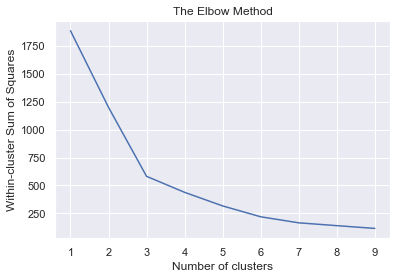

In [10]:
number_clusters = range(1,cl_num)
plt.plot(number_clusters, wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares')

Оптимальное количество кластеров - 3 (используя Elbow Method)

In [11]:
kmeans_scaled = KMeans(3)
kmeans_scaled.fit(x_scaled_1)

KMeans(n_clusters=3)

In [12]:
clusters_scaled = cl_first.copy()
cl_first['cluster_first'] = kmeans_scaled.fit_predict(x_scaled_1)

C:\Users\VADIM~1.SOK\AppData\Local\Temp/ipykernel_17084/130630813.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cl_first['cluster_first'] = kmeans_scaled.fit_predict(x_scaled_1)


In [13]:
df = pd.concat([df, cl_first['cluster_first']], axis = 1)
df[['TradePointCode','Revenue','ChequeCount','Локация_enc','cluster_first']].head()

,TradePointCode,Revenue,ChequeCount,Локация_enc,cluster_first
0,А00927,4.187031e+07,135717,5,0
1,А02072,4.892518e+07,180023,5,0
2,А02630,4.275123e+07,107701,5,0
3,А02632,4.634328e+07,104647,5,0
4,А00899,6.355079e+07,178549,5,0


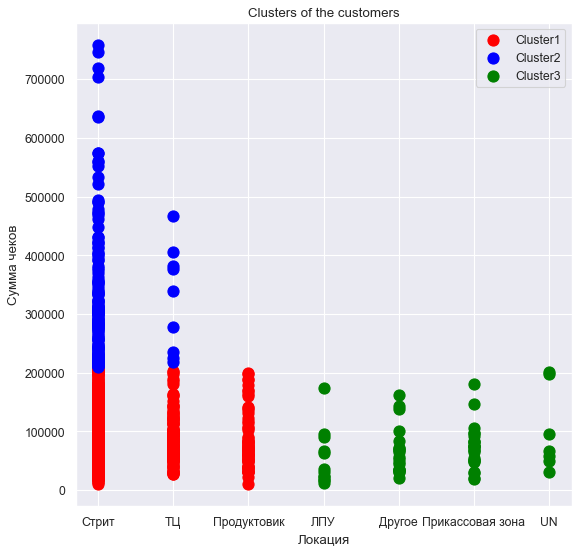

In [14]:
#visualizing the clusters
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(df.loc[df['cluster_first'] == 0, 'Локация'], df.loc[df['cluster_first'] == 0, 'ChequeCount'], 
            s = 100,c = 'red',label='Cluster1')
plt.scatter(df.loc[df['cluster_first'] == 1, 'Локация'], df.loc[df['cluster_first'] == 1, 'ChequeCount'], 
            s = 100,c = 'blue',label='Cluster2')
plt.scatter(df.loc[df['cluster_first'] == 2, 'Локация'], df.loc[df['cluster_first'] == 2, 'ChequeCount'], 
            s = 100,c = 'green',label='Cluster3')

plt.title('Clusters of the customers')
plt.xlabel('Локация')
plt.ylabel('Сумма чеков')
plt.legend()
plt.show()

In [15]:
cl_second_1 = df[df['cluster_first'] == 0]
cl_second_2 = df[df['cluster_first'] == 1]
cl_second_3 = df[df['cluster_first'] == 2]
        
print(len(cl_second_1))
print(len(cl_second_2))
print(len(cl_second_3))

721
157
65


Кластер1 - аптеки формата Стрит и ТЦ. Имеют как правило самое большое количество покупателей.
Кластер2 - аптеки формата Стрит, ТЦ, Продуктовик со стабильным средним кол-вом покупателей и максимальной представленностью в сети (721 торговая точка).
Кластер3 - аптеки формата ЛПУ, Прикассовой зоны, UN и со статусом "другое" имеют как правило небольшое количество покупателей, также, представлены в наименьшем количестве.               

### 2. Разделение магазинов по ценовым категориям для дальнейшего определения доли товаров с высокими/средними/низкими ценами и своей ценовой политикой.
Средняя стоимость чека и доли товаров  верхней ценовой категории коррелируют на 88 %, так как стоимость чека это уже факт, а доли товаров могут меняться, для определения аптек в 3 кластера с преимущественно высокой, средней и низкой ценовой категориями, для кластеризации каждого из 3х рассчитанных ранее кластеров, возьмём столбец 'mean_ch' - средняя стоимость чека и столбец 'Revenue'.

#### Разделим df на 3 части в соответствии с рассчитанными кластерами и определим необходимые столбцы для 2го этапа кластеризации по ценовым категориям.

In [16]:
cl_second_1 = cl_second_1.iloc[:,np.r_[6:7,9]]
cl_second_2 = cl_second_2.iloc[:,np.r_[6:7,9]]
cl_second_3 = cl_second_3.iloc[:,np.r_[6:7,9]]

In [17]:
cl_second_1.head()

,Revenue,mean_ch
0,4.187031e+07,308.511909
1,4.892518e+07,271.771820
2,4.275123e+07,396.943634
3,4.634328e+07,442.853368
4,6.355079e+07,355.929102


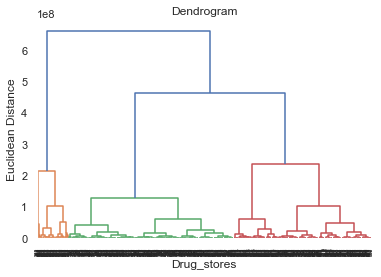

In [18]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(cl_second_1, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Drug_stores')
plt.ylabel('Euclidean Distance')
plt.show()

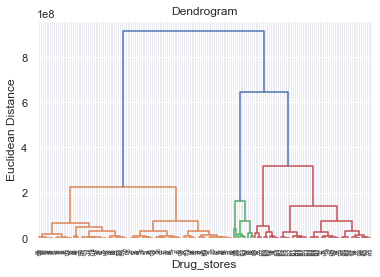

In [19]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(cl_second_2, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Drug_stores')
plt.ylabel('Euclidean Distance')
plt.show()

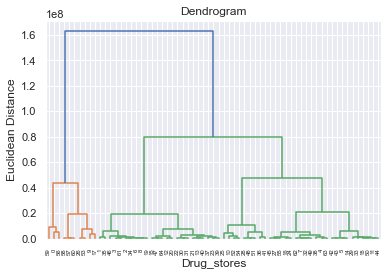

In [20]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(cl_second_3, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Drug_stores')
plt.ylabel('Euclidean Distance')
plt.show()

## Для всех 3х кластеров установим разделение на 3 типа ценовых политик.

Далее используем Hierarchical Agglomerative Clustering для определения ценовых кластеров для магазинов.

In [23]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 3, affinity = "euclidean", linkage = 'ward')

hc_pred1 = hc.fit_predict(cl_second_1)
hc_pred2 = hc.fit_predict(cl_second_2)
hc_pred3 = hc.fit_predict(cl_second_3)

In [24]:
hc_pred1 = pd.DataFrame(hc_pred1)
hc_pred2 = pd.DataFrame(hc_pred2)
hc_pred3 = pd.DataFrame(hc_pred3)

In [25]:
df2 = pd.concat([hc_pred1, hc_pred2, hc_pred3])
df2.columns = ['cluster_second']
df2.reset_index(inplace=True)
df = pd.concat([df, df2['cluster_second']], axis = 1)

In [26]:
df['cl_final'] = df['cluster_first'].astype(str) + '-' + df['cluster_second'].astype(str)
df.head()

,TradePointCode,STORE_LOCATION_LVL_NM1,STORE_LOCATION_NM,BrandName,Локация,Выкладка,Revenue,ChequeCount,TradeSquare,mean_ch,...,Товары для матери и ребенка_общ,Уход за больными_общ,Медицинская техника_общ,Мед. изделия_общ,Продукты питания_общ,Локация_enc,Выкладка_enc,cluster_first,cluster_second,cl_final
0,А00927,БЕ Центр,А00927 Орел Наугорское шоссе 88,Аптека.ру,Стрит,ОФТ,4.187031e+07,135717,98.00,308.511909,...,0.001213,0.001116,0.001018,0.000959,0.001113,5,1,0,0,0-0
1,А02072,БЕ Сибирь,А02072 Новосибирск Дзержинского 30 Аптека,Аптека.ру,Стрит,ЗФТ,4.892518e+07,180023,53.00,271.771820,...,0.001403,0.001193,0.001079,0.001492,0.001426,5,0,0,0,0-0
2,А02630,БЕ Москва,А02630 Москва ул. Островитянова 18,МосАптека,Стрит,ЗФТ,4.275123e+07,107701,45.54,396.943634,...,0.000836,0.001603,0.000902,0.001011,0.000895,5,0,0,0,0-0
3,А02632,БЕ Москва,А02632 Москва ул. Нагатинская 11 корп 1,МосАптека,Стрит,ЗФТ,4.634328e+07,104647,60.35,442.853368,...,0.001272,0.001024,0.000871,0.000925,0.000573,5,0,0,0,0-0
4,А00899,БЕ Центр,А00899 Орел Октябрьская 16/18,Озерки,Стрит,ЗФТ,6.355079e+07,178549,63.40,355.929102,...,0.002059,0.000966,0.001241,0.001498,0.000962,5,0,0,0,0-0


In [27]:
df_final = df[['TradePointCode','cl_final']]
df_final.head()

,TradePointCode,cl_final
0,А00927,0-0
1,А02072,0-0
2,А02630,0-0
3,А02632,0-0
4,А00899,0-0


In [28]:
df_final['cl_final'].sort_values().unique()

array(['0-0', '0-1', '0-2', '1-0', '1-1', '1-2', '2-0', '2-1', '2-2'],
      dtype=object)

Получили разделение всех магазинов на 3 основных кластера, учитывающих объём общего количества чеков и локацию, и разделение каждого из них на 3 вида кластеров со своей ценовой политикой.